# 1. STL-10 Supervised Learning
# 2. Unsupervised Learning with Autoencoders
# 3. Brain Tumor Segmentation

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
import cv2
import glob
from tqdm.notebook import tqdm
import numpy as np
import torchvision
from torch import nn, optim
# !pip install torchsummary
from torchsummary import summary
from sklearn.model_selection import train_test_split
# from helper import (
#     transform,
#     training_loop_supervised,
#     training_loop_unsupervised,
#     training_loop_segmentation,
#     noisy_images,
#     visualize_reconstructions,
#     unlabeled_dataset
# )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 128 # feel free to change this

# enter the path where you want to save the datasets
# make sure you save the unlabeled data in the same dir
# path = '/Users/aamil_khaan/Desktop/CS 437/Assignments/PA3'

# os.chdir(path)
from PIL import Image




## *Helper*

In [86]:

transform = transforms.Compose([
    transforms.ToTensor(),
])

def noisy_images(images, mean=0.0, std=0.5):
    """
    Adds Gaussian noise to a batch of images.

    Parameters:
    - images: tensor of images of shape (N, C, H, W), where N is the batch size,
              C is the number of channels, H is the height, and W is the width.
    - mean: Mean of the Gaussian noise.
    - std: Standard deviation of the Gaussian noise.

    Returns:
    - Tensor of noisy images of the same shape as the input.
    """
    noise = torch.randn(images.size()) * std + mean
    return torch.clamp(images + noise, 0, 1)

def training_loop_supervised(model, train_loader, test_loader, num_epochs,
                             criterion, optimizer, device, model_path):
    """
    Trains and evaluates a PyTorch image classification model, saving the model with the best accuracy on the test dataset.

    Args:
    - model: The PyTorch model to be trained and evaluated.
    - train_loader: DataLoader for the training data.
    - test_loader: DataLoader for the testing data.
    - num_epochs: Number of epochs to train the model.
    - criterion: Loss function used for training.
    - optimizer: Optimization algorithm used for training.
    - device: The device ('cuda' or 'cpu') to perform training and evaluation on.
    - model_path: Path to save the model achieving the best accuracy on the test set.

    Returns:
    - train_loss_history: List of average training losses for each epoch.
    - test_accuracy_history: List of test accuracies for each epoch.
    """
    model.to(device)
    train_loss_history = []
    test_accuracy_history = []

    for epoch in range(num_epochs):
        model.train()
        
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_loss = train_loss / len(train_loader.dataset)
        train_loss_history.append(train_loss)

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                prob, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        test_accuracy = correct / total
        test_accuracy_history.append(test_accuracy)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

        if test_accuracy == max(test_accuracy_history):
            torch.save(model.state_dict(), model_path)
    
    return train_loss_history, test_accuracy_history

# Training Loop function for unsupervised learning (can be used for both reconstruction and denoising)

def training_loop_unsupervised(model, task, train_loader, test_loader, num_epochs,
                             criterion, optimizer, device, model_path):
    """
    Trains and evaluates a PyTorch image classification model, saving the model with the best accuracy on the test dataset.

    Args:
    - model: The PyTorch model to be trained and evaluated.
    - task: string, either 'reconstruction' or 'denoising'
    - train_loader: DataLoader for the training data.
    - test_loader: DataLoader for the testing data.
    - num_epochs: Number of epochs to train the model.
    - criterion: Loss function used for training.
    - optimizer: Optimization algorithm used for training.
    - device: The device ('cuda' or 'cpu') to perform training and evaluation on.
    - model_path: Path to save the model achieving the best accuracy on the test set.

    Returns:
    - train_loss_history: List of average training losses for each epoch.
    - test_accuracy_history: List of test losses for each epoch.
    """
    model.to(device)
    train_loss_history = []
    test_accuracy_history = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs in train_loader:
            inputs = inputs.to(device)
            if task == 'denoising':
                inputs = noisy_images(inputs)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_loss = train_loss / len(train_loader.dataset)
        train_loss_history.append(train_loss)

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs in test_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, inputs)
                test_loss += loss.item() * inputs.size(0)
        test_loss = test_loss / len(test_loader.dataset)
        test_accuracy_history.append(test_loss)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

        if test_loss == min(test_accuracy_history):
            torch.save(model.state_dict(), model_path)

    return train_loss_history, test_accuracy_history

def training_loop_segmentation(model, train_loader, val_loader, num_epochs,
                               criterion, optimizer, device, model_path):
    """
    Trains and evaluates a PyTorch segmentation model, saving the model with the best performance on the validation dataset.
    Stores 10 sample outputs every 10 epochs.

    Args:
    - model: The PyTorch model to be trained and evaluated.
    - train_loader: DataLoader for the training data.
    - val_loader: DataLoader for the validation data.
    - num_epochs: Number of epochs to train the model.
    - criterion: Loss function used for training.
    - optimizer: Optimization algorithm used for training.
    - device: The device ('cuda' or 'cpu') to perform training and evaluation on.
    - model_path: Path to save the model achieving the best performance on the validation set.

    Returns:
    - train_loss_history: List of average training losses for each epoch.
    - val_loss_history: List of validation losses for each epoch.
    - sample_outputs: List of dictionaries containing images, predicted masks, and ground truth masks for sample outputs.
    """

    model.to(device)
    train_loss_history = []
    val_loss_history = []
    sample_outputs = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, masks in train_loader:
            inputs, masks = inputs.to(device), masks.to(device)
            inputs = inputs.reshape(-1, 1, 240, 240)
            masks = masks.reshape(-1, 1, 240, 240)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss = train_loss / len(train_loader.dataset)
        train_loss_history.append(train_loss)

        model.eval()
        val_loss = 0.0
        outputs_list = []

        with torch.no_grad():
            for inputs, masks in val_loader:
                inputs, masks = inputs.to(device), masks.to(device)
                inputs = inputs.reshape(-1, 1, 240, 240)
                masks = masks.reshape(-1, 1, 240, 240)
                outputs = model(inputs)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                output_list = []
                if epoch % 3 == 0:
                    for index in range(0, 3):
                        output_list.append({'image': inputs[index], 'predicted_mask': outputs[index], 'ground_truth_mask': masks[index]})
                        
                    sample_outputs.append(output_list)

        val_loss = val_loss / len(val_loader.dataset)
        val_loss_history.append(val_loss)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        if val_loss == min(val_loss_history):
            torch.save(model.state_dict(), model_path)

    return train_loss_history, val_loss_history, sample_outputs


def visualize_reconstructions(test_loader, model, device, task='reconstruction'):
    """
    Visualizes original and reconstructed images from a test dataset.

    Args:
    - test_loader: DataLoader for the test dataset.
    - model: Trained model for image reconstruction or denoising.
    - device: The device (e.g., 'cuda' or 'cpu') the model is running on.
    - task: The task to perform - either 'reconstruction' or 'denoising'.
    """
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    if task == 'denoising':
        images = noisy_images(images)  # Apply noise if the task is denoising

    recons = model(images.to(device))

    images_np = images.cpu().numpy()
    recons_np = recons.cpu().detach().numpy()

    indices = np.random.choice(images_np.shape[0], 9, replace=False)
    selected_images = images_np[indices]
    selected_recons = recons_np[indices]
    selected_labels = labels.numpy()[indices]

    fig, axs = plt.subplots(2, 9, figsize=(15, 4))

    for i in range(9):
        axs[0, i].imshow(np.transpose(selected_images[i], (1, 2, 0)), interpolation='none', cmap='gray')
        axs[0, i].set_title(f"GT: {selected_labels[i]}")
        axs[0, i].axis('off')

        axs[1, i].imshow(np.transpose(selected_recons[i], (1, 2, 0)), interpolation='none', cmap='gray')
        axs[1, i].set_title(f"Recon: {selected_labels[i]}")
        axs[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Dataset class for Loading Unlabeled Images:
class UnlabeledImageDataset(Dataset):
    def __init__(self, folder, split='train', split_ratio=0.8):
        self.folder = folder
        self.imgs = os.listdir(folder)
        self.split = split
        self.split_ratio = split_ratio
        
        num_imgs = len(self.imgs)
        self.split_index = int(num_imgs * split_ratio)
        
        if split == 'train':
            self.imgs = self.imgs[:self.split_index]
        elif split == 'val':
            self.imgs = self.imgs[self.split_index:]

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder, self.imgs[idx])
        img_np = cv2.imread(img_path)
        img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
        img_pt = transform(img_np) # converting to pytorch tensor
        return img_pt
 
class UnlabeledImageDataset_2(Dataset):
    def __init__(self, folder, split='train', split_ratio=0.8):
        self.folder = folder
        self.transform = transform
        all_imgs = os.listdir(folder)
        num_imgs = len(all_imgs)
        split_index = int(num_imgs * split_ratio)

        if split == 'train':
            self.imgs = all_imgs[:split_index]
        elif split == 'val':
            self.imgs = all_imgs[split_index:]

        self.images = []
        for img_name in tqdm(self.imgs):
            img_path = os.path.join(self.folder, img_name)
            img_np = cv2.imread(img_path)
            img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
            
            if self.transform:
                img_np = self.transform(img_np)
                
            self.images.append(img_np)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # since images are already preloaded, just retrieve from the list
        return self.images[idx]
    
def unlabeled_dataset(ram_above_16: bool = False):
    if ram_above_16:
        return UnlabeledImageDataset_2
    else:
        return UnlabeledImageDataset

In [4]:
# Load the STL-10 train and test datasets below:
class LoadSTL10(Dataset):
    def __init__(self, data_path, labels, transform, type):
        self.data_path = data_path
        self.labels = labels
        self.transform = transform
        self.type = type
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_path, f"{self.type}{idx+1}.png")
        image = Image.open(img_name)
        image = self.transform(image)
        label = self.labels[idx]
        return image, label
        
trainingData = '/kaggle/input/stl-images/STL-10/train_images'
testingData = '/kaggle/input/stl-images/STL-10/test_images'
train_labels = np.load('/kaggle/input/stl-labels/train_labels.npy')
test_labels = np.load('/kaggle/input/stl-labels/test_labels.npy')
train_dataset = LoadSTL10(trainingData, train_labels, transform, "train_image_png_")
test_dataset = LoadSTL10(testingData, test_labels, transform, "test_image_png_")
# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

#### For now, we'll only work with the labeled data for supervised training. Let's visualize the data:

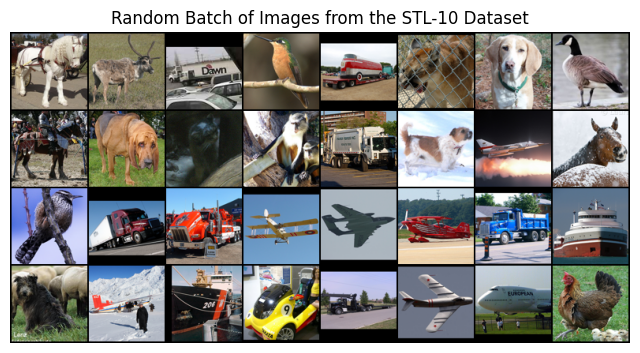

In [5]:
def imshow(img):
    img = img
    npimg = img.numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.title("Random Batch of Images from the STL-10 Dataset")
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, _ = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[0:32]))


## Supervised Learning - CNN Classifier

In [6]:
class ClassifierCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.hidden = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(16*24*24, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.hidden(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        x = nn.functional.softmax(x, dim=1)
        return x


In [7]:
model = ClassifierCNN()
model.to(device)
summary(model, input_size=(3, 96, 96), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 8, 96, 96]             224
              ReLU-2           [128, 8, 96, 96]               0
         MaxPool2d-3           [128, 8, 48, 48]               0
            Conv2d-4          [128, 16, 48, 48]           1,168
              ReLU-5          [128, 16, 48, 48]               0
         MaxPool2d-6          [128, 16, 24, 24]               0
            Linear-7                  [128, 50]         460,850
              ReLU-8                  [128, 50]               0
            Linear-9                  [128, 10]             510
Total params: 462,752
Trainable params: 462,752
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 13.50
Forward/backward pass size (MB): 243.11
Params size (MB): 1.77
Estimated Total Size (MB): 258.37
--------------------------------------

#### Training the Model

In [8]:
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 15
model_path = '/kaggle/working/CNN-Classifier.pth'
train_loss_history, test_accuracy_history = training_loop_supervised(model, train_loader, test_loader, num_epochs, criteria, optimizer, device, model_path)

Epoch 1/15, Train Loss: 2.2687, Test Accuracy: 0.1999
Epoch 2/15, Train Loss: 2.1850, Test Accuracy: 0.3170
Epoch 3/15, Train Loss: 2.1352, Test Accuracy: 0.3155
Epoch 4/15, Train Loss: 2.1113, Test Accuracy: 0.3640
Epoch 5/15, Train Loss: 2.0773, Test Accuracy: 0.3774
Epoch 6/15, Train Loss: 2.0556, Test Accuracy: 0.3713
Epoch 7/15, Train Loss: 2.0620, Test Accuracy: 0.4034
Epoch 8/15, Train Loss: 2.0300, Test Accuracy: 0.4042
Epoch 9/15, Train Loss: 2.0094, Test Accuracy: 0.3992
Epoch 10/15, Train Loss: 1.9990, Test Accuracy: 0.4382
Epoch 11/15, Train Loss: 1.9726, Test Accuracy: 0.4404
Epoch 12/15, Train Loss: 1.9612, Test Accuracy: 0.4547
Epoch 13/15, Train Loss: 1.9469, Test Accuracy: 0.4502
Epoch 14/15, Train Loss: 1.9418, Test Accuracy: 0.4225
Epoch 15/15, Train Loss: 1.9301, Test Accuracy: 0.4665


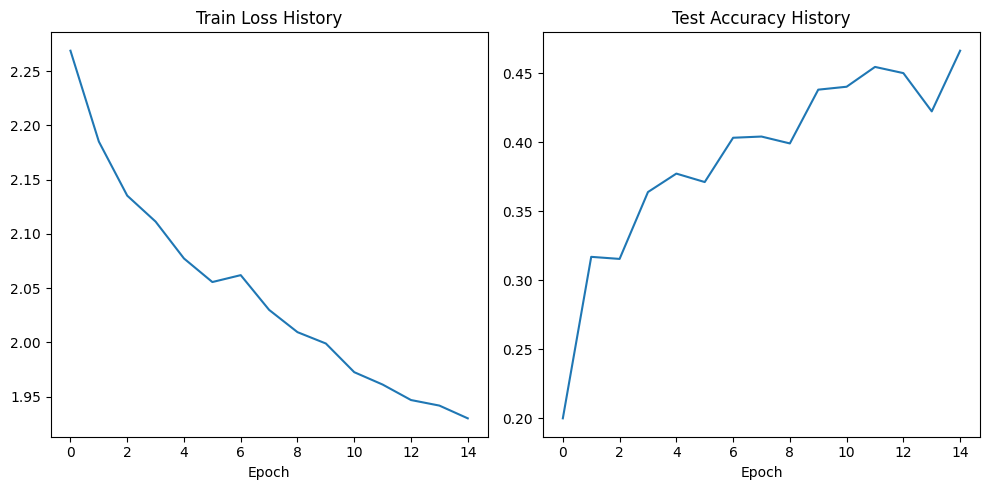

In [9]:

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(train_loss_history)
axs[0].set_title('Train Loss History')
axs[0].set_xlabel('Epoch')
axs[1].plot(test_accuracy_history)
axs[1].set_title('Test Accuracy History')
axs[1].set_xlabel('Epoch')
plt.tight_layout()
plt.show()


### Small fun task: Let's evaluate a pre-trained Model (ResNET18) on the STL-10 data and see what accuracy we can achieve.

In [10]:
from torchvision.models import resnet18, ResNet18_Weights

In [11]:
model = resnet18(pretrained=True, weights=ResNet18_Weights)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 135MB/s] 


In [12]:
# Freeze gradients and replace the classifier layer:

for i in model.parameters():
    i.requires_grad = False
    
model.fc = nn.Linear(model.fc.in_features , 10)
model.to(device)
summary(model, input_size=(3,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,864
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
       BasicBlock-11           [-1, 64, 24, 24]               0
           Conv2d-12           [-1, 64, 24, 24]          36,864
      BatchNorm2d-13           [-1, 64, 24, 24]             128
             ReLU-14           [-1, 64,

### Training ResNet-18 & Plotting the Accuracy History

In [13]:
criteria = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 7
model_path = '/kaggle/working/CNN-resnets.pth'
model.to(device)
train_loss_history, test_accuracy_history = training_loop_supervised(model, train_loader, test_loader, num_epochs, criteria, optimizer, device, model_path)

Epoch 1/7, Train Loss: 1.5857, Test Accuracy: 0.6909
Epoch 2/7, Train Loss: 0.8817, Test Accuracy: 0.7455
Epoch 3/7, Train Loss: 0.7297, Test Accuracy: 0.7551
Epoch 4/7, Train Loss: 0.6548, Test Accuracy: 0.7651
Epoch 5/7, Train Loss: 0.6097, Test Accuracy: 0.7672
Epoch 6/7, Train Loss: 0.5808, Test Accuracy: 0.7730
Epoch 7/7, Train Loss: 0.5470, Test Accuracy: 0.7749


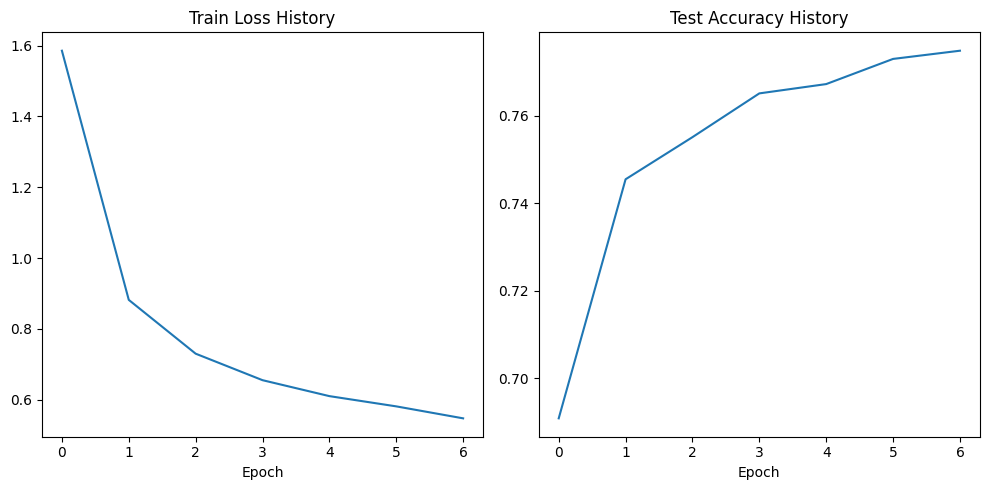

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(train_loss_history)
axs[0].set_title('Train Loss History')
axs[0].set_xlabel('Epoch')
axs[1].plot(test_accuracy_history)
axs[1].set_title('Test Accuracy History')
axs[1].set_xlabel('Epoch')
plt.tight_layout()
plt.show()

## Training an AutoEncoder with Unlabeled Data for Prediciton on Labeled Data

#### Anyway, back to creating our own models. We will attempt to harness the power of self-supervised learning using an AutoEncoder.

The idea is to train a model to reconstruct (massive amounts of) unlabeled data in an unsupervised manner, and then use the encoder's learned embeddings to train the model on limited training data.

For this, we will create a Deep Encoder-Decoder convolutional model. We'll train it on the unlabeled images from the STL-10 dataset, and then use the encoder with a classifier in another model class for classification.

In [15]:


class EncoderDecoderCNN(nn.Module):
    def __init__(self, in_chans=3, dropout_rate=0.2):
        super(EncoderDecoderCNN, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_chans, 16, kernel_size=3, stride=3, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(dropout_rate),
            nn.Conv2d(16, 28, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(28),
            nn.ReLU(),
            nn.Dropout2d(dropout_rate),
            nn.Conv2d(28, 32, kernel_size=5, stride=3, padding=2),
            
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 28, kernel_size=5, stride=3, padding=2),
            nn.ConvTranspose2d(28, 16, kernel_size=3, stride=1, padding=2),
            nn.ConvTranspose2d(16, in_chans, kernel_size=3, stride=3, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [17]:
# load the model
model = EncoderDecoderCNN()
model.to(device)
summary(model, input_size=(3, 96, 96), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 16, 32, 32]             448
       BatchNorm2d-2          [128, 16, 32, 32]              32
              ReLU-3          [128, 16, 32, 32]               0
         Dropout2d-4          [128, 16, 32, 32]               0
            Conv2d-5          [128, 28, 34, 34]           4,060
       BatchNorm2d-6          [128, 28, 34, 34]              56
              ReLU-7          [128, 28, 34, 34]               0
         Dropout2d-8          [128, 28, 34, 34]               0
            Conv2d-9          [128, 32, 12, 12]          22,432
  ConvTranspose2d-10          [128, 28, 34, 34]          22,428
  ConvTranspose2d-11          [128, 16, 32, 32]           4,048
  ConvTranspose2d-12           [128, 3, 96, 96]             435
          Sigmoid-13           [128, 3, 96, 96]               0
Total params: 53,939
Trainable params: 

### Load the Dataset and train your AE model

In [18]:
folder = '/kaggle/input/stl-images/STL-10/unlabeled_images' # path to the folder containing the images

ram_above_16 = True # set to True if you have more than 16GB of RAM

UnlabeledImageDataset = unlabeled_dataset(ram_above_16)
train_dataset = UnlabeledImageDataset(folder=folder, split='train')
val_dataset = UnlabeledImageDataset(folder=folder, split='val')

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

### Train Your Model

In [19]:
criteria = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 17
model_path = '/kaggle/working/CNN-EncoderDecoder.pth'
model.to(device)
train_loss_history, test_loss_history = training_loop_unsupervised(model, 'reconstruction', train_loader, test_loader, num_epochs, criteria, optimizer, device, model_path)

Epoch 1/17, Train Loss: 0.0164, Test Loss: 0.0076
Epoch 2/17, Train Loss: 0.0090, Test Loss: 0.0069
Epoch 3/17, Train Loss: 0.0080, Test Loss: 0.0054
Epoch 4/17, Train Loss: 0.0072, Test Loss: 0.0054
Epoch 5/17, Train Loss: 0.0068, Test Loss: 0.0048
Epoch 6/17, Train Loss: 0.0065, Test Loss: 0.0046
Epoch 7/17, Train Loss: 0.0063, Test Loss: 0.0041
Epoch 8/17, Train Loss: 0.0061, Test Loss: 0.0054
Epoch 9/17, Train Loss: 0.0060, Test Loss: 0.0047
Epoch 10/17, Train Loss: 0.0059, Test Loss: 0.0048
Epoch 11/17, Train Loss: 0.0058, Test Loss: 0.0043
Epoch 12/17, Train Loss: 0.0058, Test Loss: 0.0045
Epoch 13/17, Train Loss: 0.0056, Test Loss: 0.0042
Epoch 14/17, Train Loss: 0.0056, Test Loss: 0.0037
Epoch 15/17, Train Loss: 0.0055, Test Loss: 0.0049
Epoch 16/17, Train Loss: 0.0055, Test Loss: 0.0037
Epoch 17/17, Train Loss: 0.0054, Test Loss: 0.0044


### Visualize the Results - Linear AE

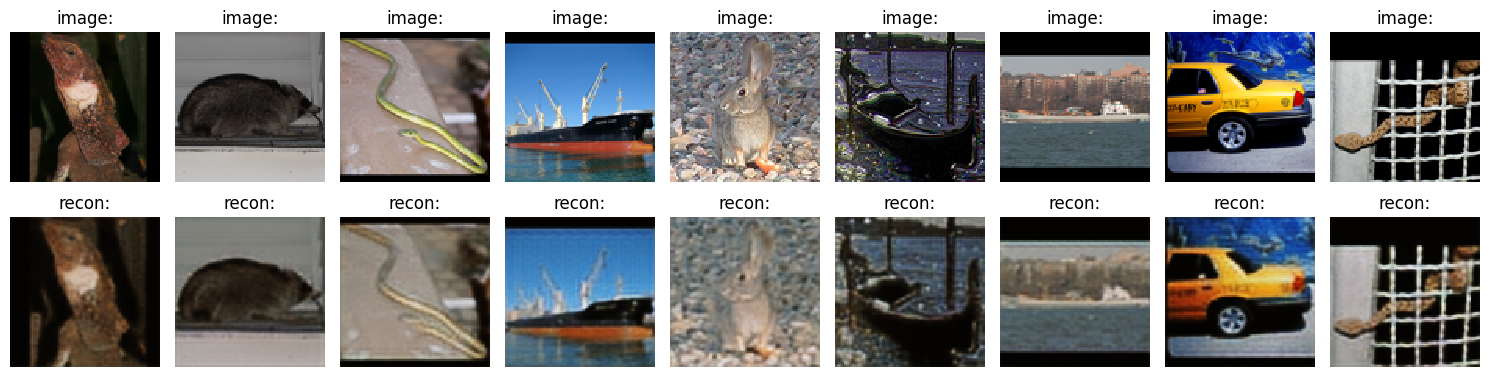

In [20]:
def visualize_reconstructions_own(test_loader, model, device, task='reconstruction'):
    """
    Visualizes original and reconstructed images from a test dataset.

    Args:
    - test_loader: DataLoader for the test dataset.
    - model: Trained model for image reconstruction or denoising.
    - device: The device (e.g., 'cuda' or 'cpu') the model is running on.
    - task: The task to perform - either 'reconstruction' or 'denoising'.
    """
    dataiter = iter(test_loader)
    images = next(dataiter)

    if task == 'denoising':
        images = noisy_images(images)  # Apply noise if the task is denoising

    recons = model(images.to(device))

    images_np = images.cpu().numpy()
    recons_np = recons.cpu().detach().numpy()

    indices = np.random.choice(images_np.shape[0], 9, replace=False)
    selected_images = images_np[indices]
    selected_recons = recons_np[indices]
    

    fig, axs = plt.subplots(2, 9, figsize=(15, 4))

    for i in range(9):
        axs[0, i].imshow(np.transpose(selected_images[i], (1, 2, 0)), interpolation='none', cmap='gray')
        axs[0, i].set_title(f"image:")
        axs[0, i].axis('off')

        axs[1, i].imshow(np.transpose(selected_recons[i], (1, 2, 0)), interpolation='none', cmap='gray')
        axs[1, i].set_title(f"recon:")
        axs[1, i].axis('off')

    plt.tight_layout()
    plt.show()
    
visualize_reconstructions_own(test_loader, model, device, task='reconstruction')

#### Now, use the encoder from this AE (freeze its gradients) with a classifier layer to train the model.

In [22]:
class EncoderClassifier(nn.Module):
    def __init__(self, encoder):
        super(EncoderClassifier, self).__init__()
        self.encoder = encoder
        for i in self.encoder.parameters():
            i.requires_grad = False
        self.classifier = nn.Sequential(
            nn.Linear(32*12*12, 10),
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
        

In [23]:
model = EncoderClassifier(EncoderDecoderCNN().encoder)
model.to(device)
summary(model, input_size=(3, 96, 96), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 16, 32, 32]             448
       BatchNorm2d-2          [128, 16, 32, 32]              32
              ReLU-3          [128, 16, 32, 32]               0
         Dropout2d-4          [128, 16, 32, 32]               0
            Conv2d-5          [128, 28, 34, 34]           4,060
       BatchNorm2d-6          [128, 28, 34, 34]              56
              ReLU-7          [128, 28, 34, 34]               0
         Dropout2d-8          [128, 28, 34, 34]               0
            Conv2d-9          [128, 32, 12, 12]          22,432
           Linear-10                  [128, 10]          46,090
Total params: 73,118
Trainable params: 46,090
Non-trainable params: 27,028
----------------------------------------------------------------
Input size (MB): 13.50
Forward/backward pass size (MB): 194.95
Params size (MB): 0.28
Estim

In [24]:
# create dataloaders again for the train and test split of the STL-10 dataset
trainingData = '/kaggle/input/stl-images/STL-10/train_images'
testingData = '/kaggle/input/stl-images/STL-10/test_images'
train_labels = np.load('/kaggle/input/stl-labels/train_labels.npy')
test_labels = np.load('/kaggle/input/stl-labels/test_labels.npy')
train_dataset = LoadSTL10(trainingData, train_labels, transform, "train_image_png_")
test_dataset = LoadSTL10(testingData, test_labels, transform, "test_image_png_")
# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Train your model

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 40
model_path = '/kaggle/working/CNN-Encoder-Classifier.pth'
train_loss_history, test_accuracy_history = training_loop_supervised(model, train_loader, test_loader, num_epochs, criterion, optimizer, device, model_path)




Epoch 1/40, Train Loss: 2.2158, Test Accuracy: 0.2715
Epoch 2/40, Train Loss: 2.0513, Test Accuracy: 0.3292
Epoch 3/40, Train Loss: 1.9709, Test Accuracy: 0.3488
Epoch 4/40, Train Loss: 1.9229, Test Accuracy: 0.3569
Epoch 5/40, Train Loss: 1.8949, Test Accuracy: 0.3629
Epoch 6/40, Train Loss: 1.8602, Test Accuracy: 0.3721
Epoch 7/40, Train Loss: 1.8308, Test Accuracy: 0.3877
Epoch 8/40, Train Loss: 1.8116, Test Accuracy: 0.3905
Epoch 9/40, Train Loss: 1.7861, Test Accuracy: 0.3887
Epoch 10/40, Train Loss: 1.7776, Test Accuracy: 0.3934
Epoch 11/40, Train Loss: 1.7482, Test Accuracy: 0.3949
Epoch 12/40, Train Loss: 1.7355, Test Accuracy: 0.3976
Epoch 13/40, Train Loss: 1.7255, Test Accuracy: 0.4001
Epoch 14/40, Train Loss: 1.7069, Test Accuracy: 0.3985
Epoch 15/40, Train Loss: 1.6964, Test Accuracy: 0.4020
Epoch 16/40, Train Loss: 1.6909, Test Accuracy: 0.4056
Epoch 17/40, Train Loss: 1.6743, Test Accuracy: 0.4071
Epoch 18/40, Train Loss: 1.6544, Test Accuracy: 0.4096
Epoch 19/40, Train 

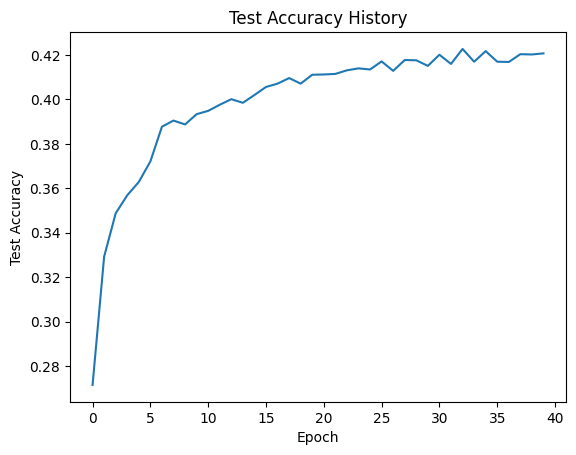

In [26]:
plt.plot(test_accuracy_history)
plt.title('Test Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.show()

## Brain Tumor Segmentation 

We'll be training an AE model to segment brain tumors from patients' MRI scans. The ground truth will be the binary mask, and the output of the Decoder layer must be between 0 and 1 as well for all elements.

In [27]:
image_dir = '/kaggle/input/brain-tumor-segmentation/images'
ground_truths_dir = '/kaggle/input/brain-tumor-segmentation/masks'

# Function for preprocessing images and masks
def preprocessing(image, mask):

    image = cv2.resize(image, (240, 240)) 
    image = image/255.0 
    mask = cv2.resize(mask, (240, 240)) 
    mask = (mask > 0).astype(np.uint8) 
    return image, mask


data = []
ground_truths = []

for image_name in os.listdir(image_dir):
    if image_name.endswith(".png"):
        image = cv2.imread(os.path.join(image_dir, image_name),cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(os.path.join(ground_truths_dir, image_name), cv2.IMREAD_GRAYSCALE)
        if image is None or mask is None:
            continue
        image, mask = preprocessing(image, mask)
        data.append(image)
        ground_truths.append(mask)
        
data = np.array(data)
ground_truths = np.array(ground_truths)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(data, ground_truths, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)    
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


### Visualize a random set of images along with their corresponding binary masks

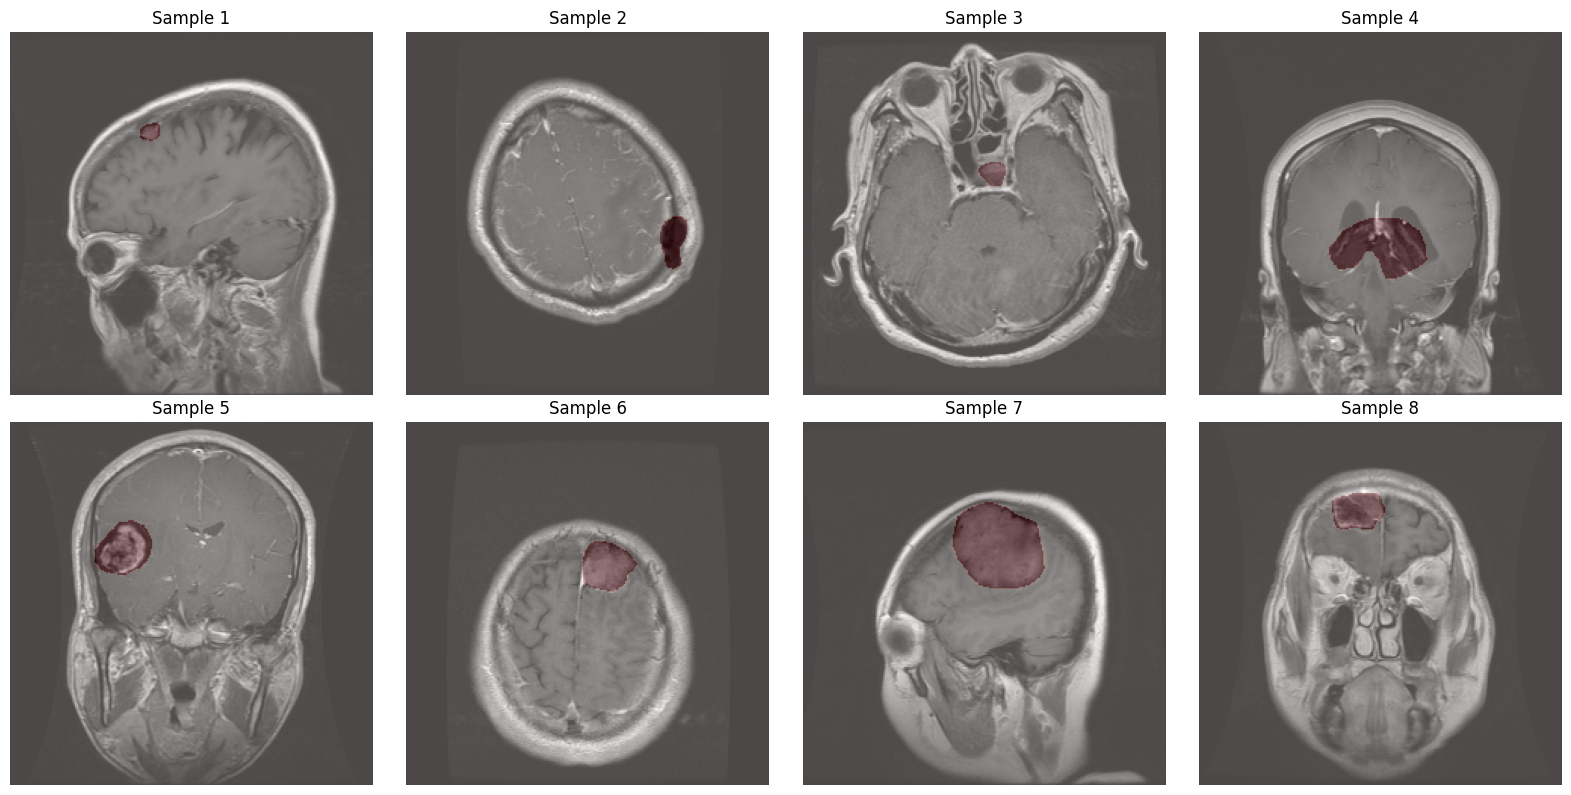

In [29]:
# Function to visualize images and masks
def visualize_samples(images, masks):
    num_samples = len(images)
    fig, axes = plt.subplots(nrows=2, ncols=num_samples // 2, figsize=(16, 8))

    for i, (image, mask) in enumerate(zip(images, masks)):
        ax = axes[i // (num_samples // 2), i % (num_samples // 2)]
        ax.imshow(image, cmap='gray')
        ax.imshow(mask, alpha=0.3, cmap='Reds')
        ax.axis('off')
        ax.set_title(f'Sample {i+1}')

    plt.tight_layout()
    plt.show()

# Select 8 random samples from the training dataset
random_indices = np.random.choice(len(train_dataset), 8, replace=False)
random_samples = [(train_dataset[i][0].numpy(), train_dataset[i][1].numpy()) for i in random_indices]

# Separate images and masks
random_images = [sample[0] for sample in random_samples]
random_masks = [sample[1] for sample in random_samples]

# Visualize the random samples
visualize_samples(random_images, random_masks)


In [30]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, prediction, target, smooth=1e-6):
        numerator = 2 + (prediction * target).sum() + smooth
        denominator = (prediction * prediction).sum() + (target * target).sum() + smooth
        diceLoss = 1 - (numerator / denominator)
        return diceLoss

### Creating an AutoEncoder Model for Brain Tumor Segmentation

In [32]:

class EncoderDecoderCNN(nn.Module):
    def __init__(self):
        super(EncoderDecoderCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout2d(0.18),
            nn.Conv2d(8, 20, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.Dropout2d(0.18),
            nn.Conv2d(20, 32, kernel_size=5, stride=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.18),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 20, kernel_size=5, stride=3, padding=1),
            nn.ConvTranspose2d(20, 8, kernel_size=3, stride=1, padding=1),
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
        


In [33]:
# load the model
model = EncoderDecoderCNN()
model.to(device)
summary(model, input_size=(1, 240, 240), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [128, 8, 240, 240]              80
       BatchNorm2d-2         [128, 8, 240, 240]              16
              ReLU-3         [128, 8, 240, 240]               0
         Dropout2d-4         [128, 8, 240, 240]               0
            Conv2d-5        [128, 20, 240, 240]           1,460
       BatchNorm2d-6        [128, 20, 240, 240]              40
              ReLU-7        [128, 20, 240, 240]               0
         Dropout2d-8        [128, 20, 240, 240]               0
            Conv2d-9          [128, 32, 80, 80]          16,032
      BatchNorm2d-10          [128, 32, 80, 80]              64
             ReLU-11          [128, 32, 80, 80]               0
        Dropout2d-12          [128, 32, 80, 80]               0
  ConvTranspose2d-13        [128, 20, 240, 240]          16,020
  ConvTranspose2d-14         [128, 8, 2

### Training Model

In [87]:
criterion = DiceLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20

model_path = '/kaggle/working/EncoderDecoderCNN.pth'
train_hist, test_hist, sample_outputs = training_loop_segmentation(model, train_loader, test_loader, num_epochs,
                                                 criterion, optimizer, device, model_path)

Epoch 1/20, Train Loss: 0.0069, Val Loss: 0.0068
Epoch 2/20, Train Loss: 0.0068, Val Loss: 0.0068
Epoch 3/20, Train Loss: 0.0068, Val Loss: 0.0068
Epoch 4/20, Train Loss: 0.0068, Val Loss: 0.0068
Epoch 5/20, Train Loss: 0.0068, Val Loss: 0.0068
Epoch 6/20, Train Loss: 0.0068, Val Loss: 0.0067
Epoch 7/20, Train Loss: 0.0068, Val Loss: 0.0068
Epoch 8/20, Train Loss: 0.0068, Val Loss: 0.0067
Epoch 9/20, Train Loss: 0.0068, Val Loss: 0.0067
Epoch 10/20, Train Loss: 0.0068, Val Loss: 0.0068
Epoch 11/20, Train Loss: 0.0068, Val Loss: 0.0067
Epoch 12/20, Train Loss: 0.0068, Val Loss: 0.0068
Epoch 13/20, Train Loss: 0.0068, Val Loss: 0.0067
Epoch 14/20, Train Loss: 0.0068, Val Loss: 0.0068
Epoch 15/20, Train Loss: 0.0068, Val Loss: 0.0067
Epoch 16/20, Train Loss: 0.0068, Val Loss: 0.0067
Epoch 17/20, Train Loss: 0.0068, Val Loss: 0.0067
Epoch 18/20, Train Loss: 0.0068, Val Loss: 0.0067
Epoch 19/20, Train Loss: 0.0068, Val Loss: 0.0067
Epoch 20/20, Train Loss: 0.0068, Val Loss: 0.0067


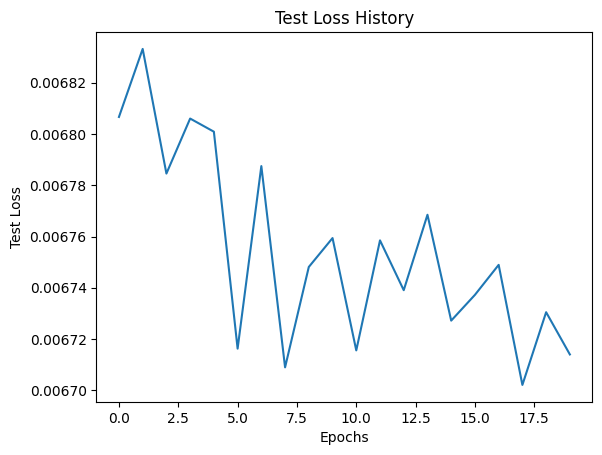

In [88]:
plt.plot(test_hist)
plt.xlabel("Epochs")
plt.ylabel("Test Loss")
plt.title("Test Loss History")
plt.show()


In [89]:
def visualize_sample_outputs(sample_outputs):
    """
    Visualizes sample outputs (images, predicted masks, and ground truth masks) in a single row for each set of samples.

    Args:
    - sample_outputs: List of dictionaries containing images, predicted masks, and ground truth masks for sample outputs.
    """

    for samples in sample_outputs:
        num_samples = len(samples)
        num_cols = num_samples * 3  # Three columns per sample (image, predicted mask, ground truth mask)

        fig, axs = plt.subplots(1, num_cols, figsize=(num_samples * 6, 4))

        for i, sample in enumerate(samples):
            image = sample['image'].squeeze().cpu().numpy()
            predicted_mask = sample['predicted_mask'].squeeze().cpu().numpy()
            ground_truth_mask = sample['ground_truth_mask'].squeeze().cpu().numpy()

            # Plotting image
            axs[i * 3].imshow(image, cmap='gray')
            axs[i * 3].set_title(f'Image {i+1}')
            axs[i * 3].axis('off')

            # Plotting predicted mask
            axs[i * 3 + 1].imshow(predicted_mask, cmap='gray')
            axs[i * 3 + 1].set_title(f'Predicted Mask {i+1}')
            axs[i * 3 + 1].axis('off')

            # Plotting ground truth mask
            axs[i * 3 + 2].imshow(ground_truth_mask, cmap='gray')
            axs[i * 3 + 2].set_title(f'Ground Truth {i+1}')
            axs[i * 3 + 2].axis('off')

        plt.tight_layout()
        plt.show()


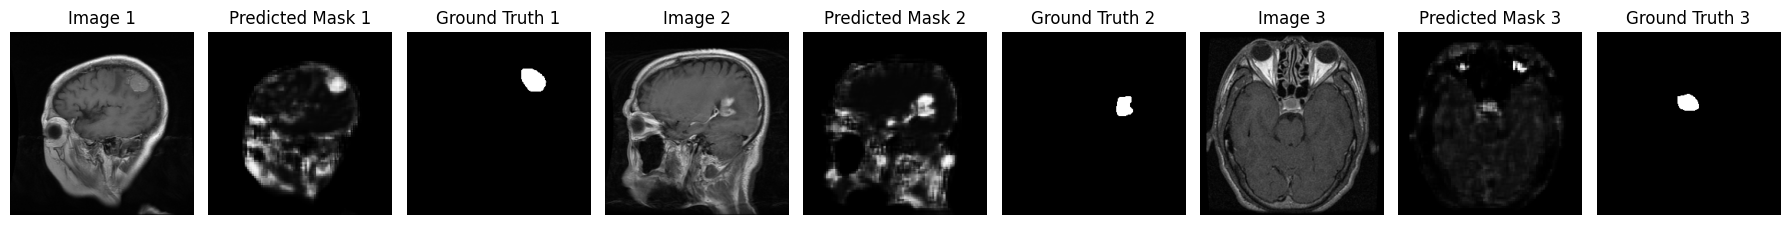

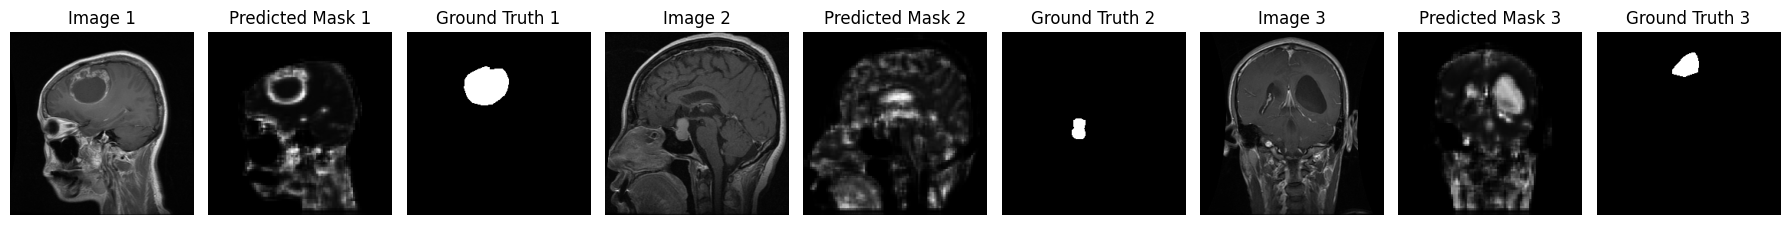

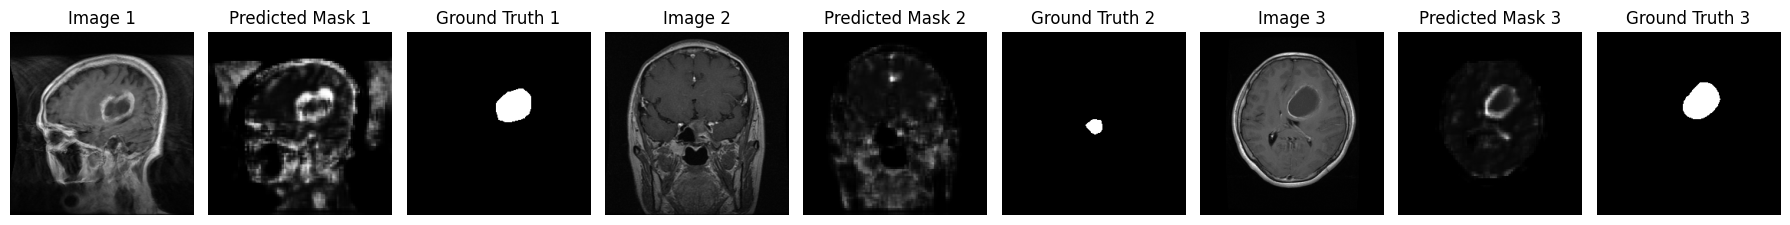

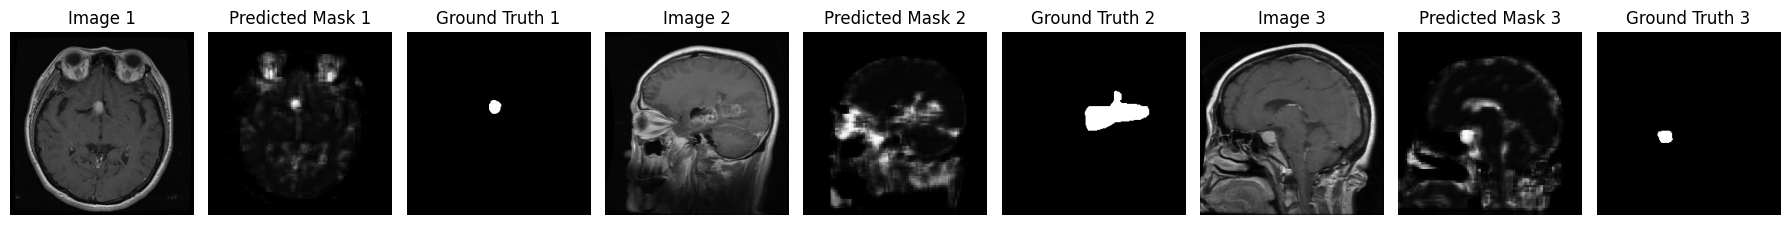

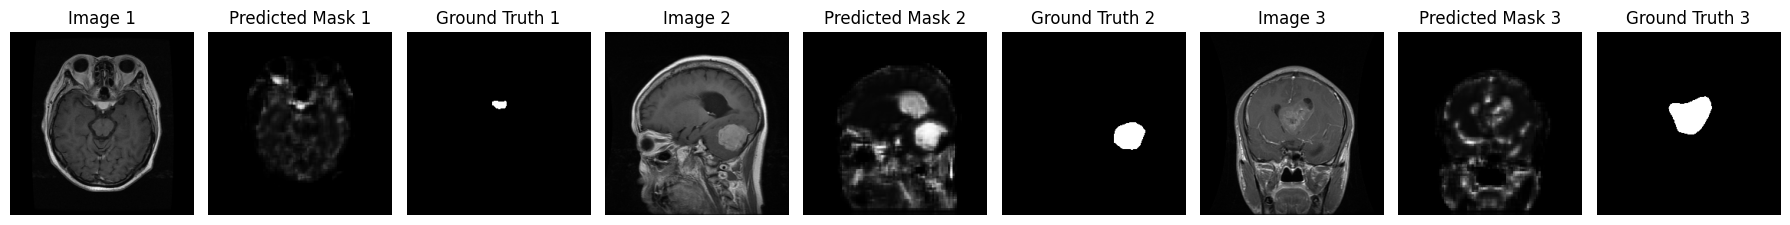

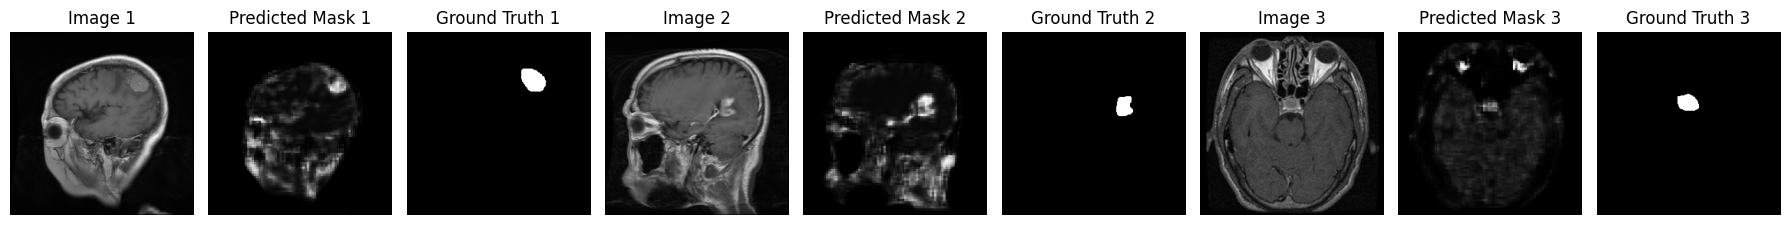

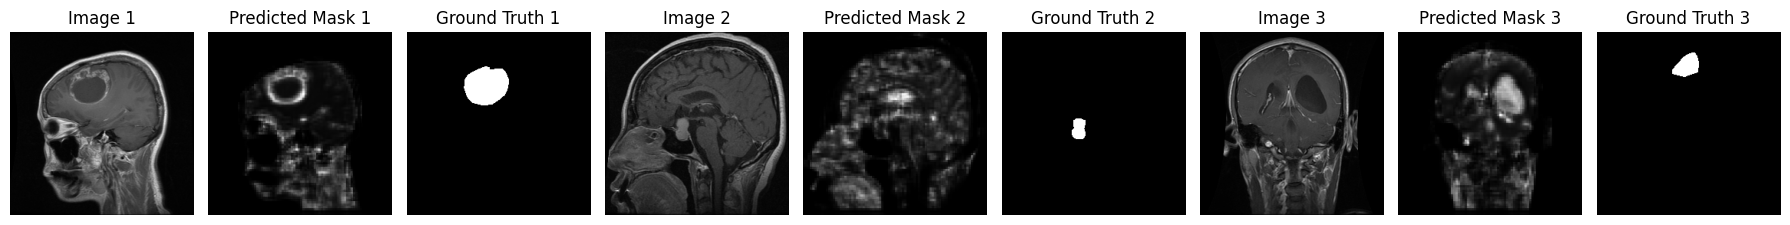

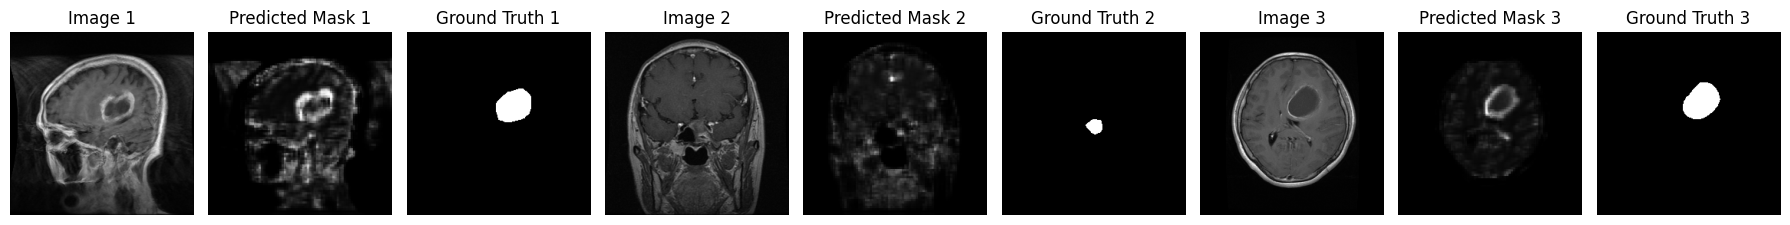

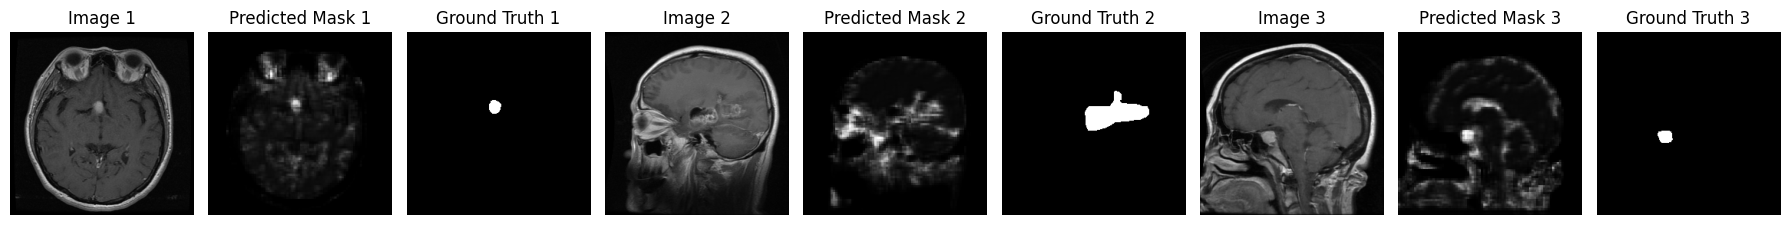

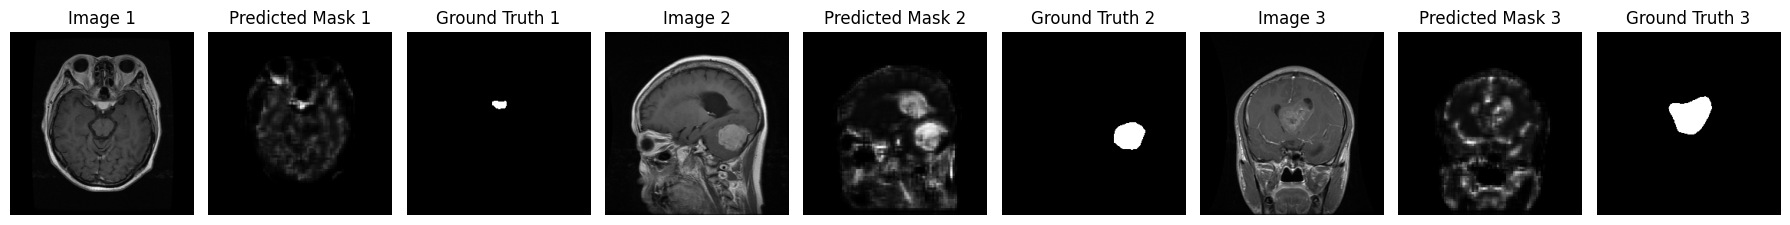

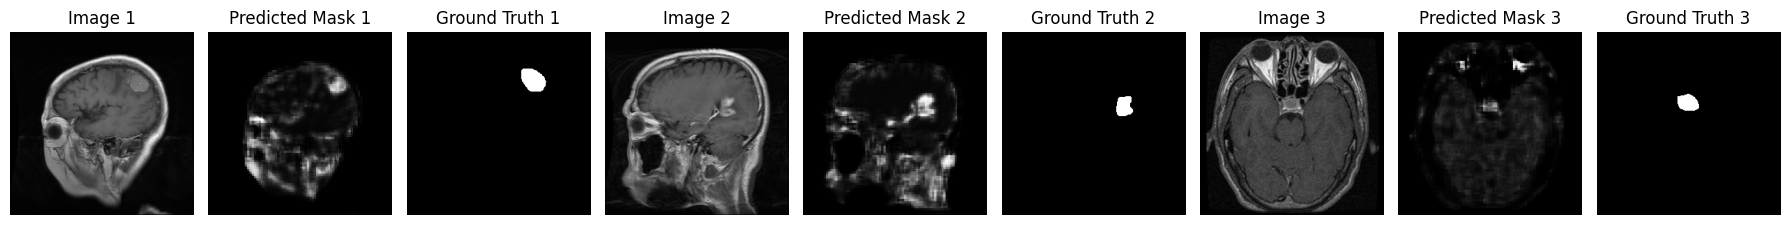

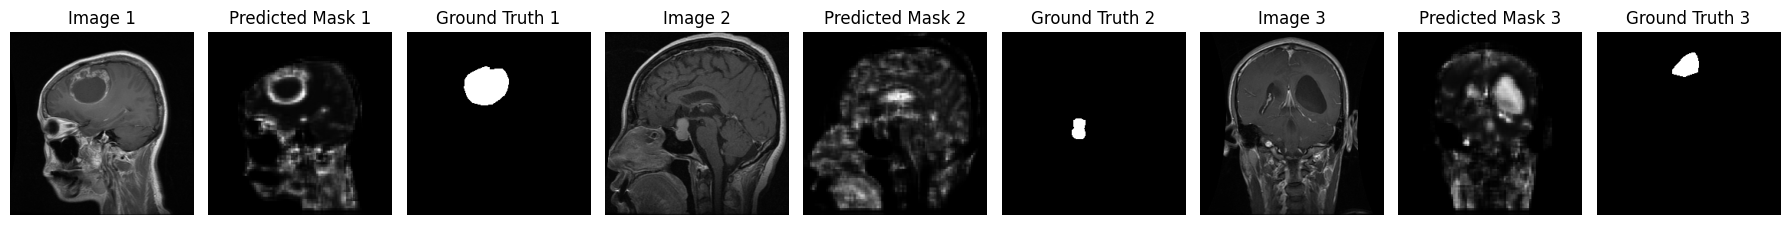

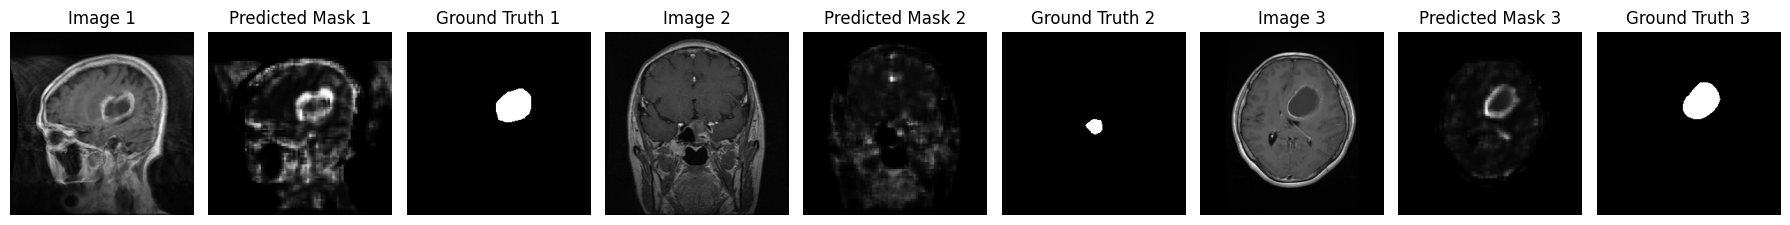

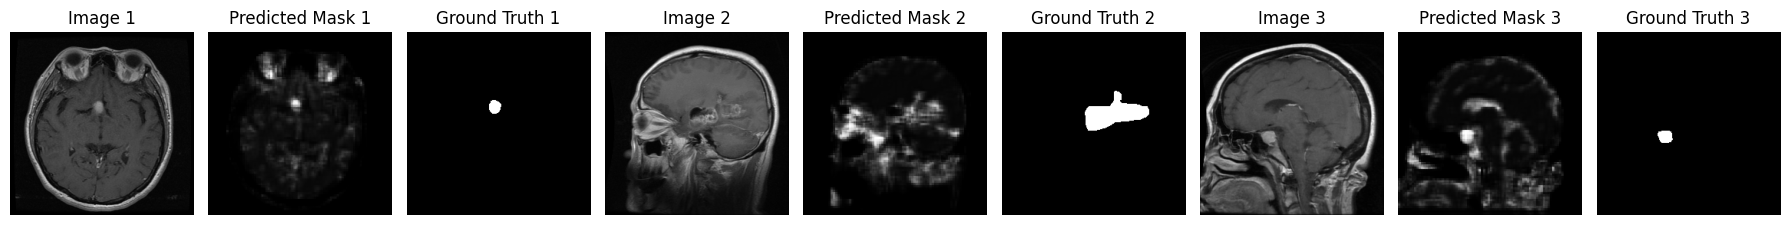

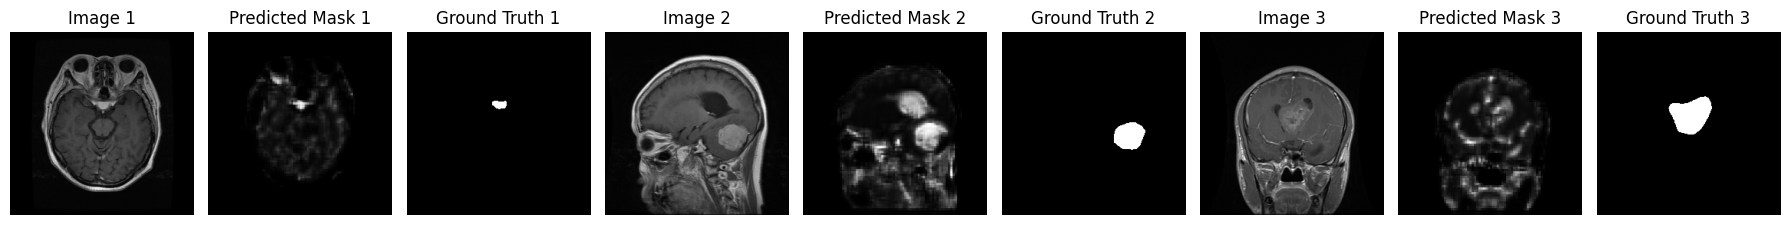

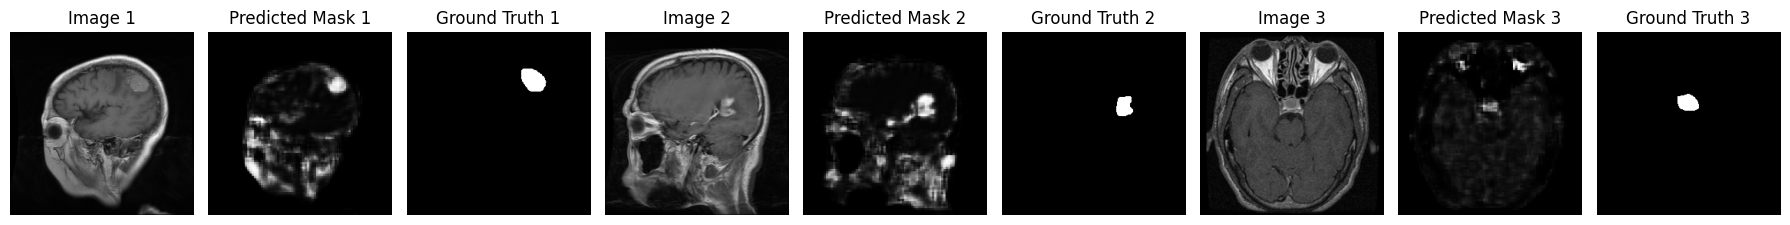

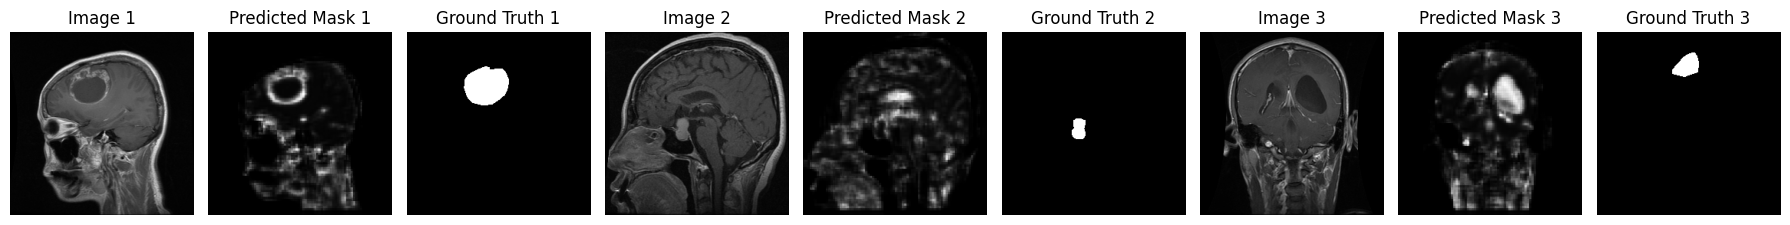

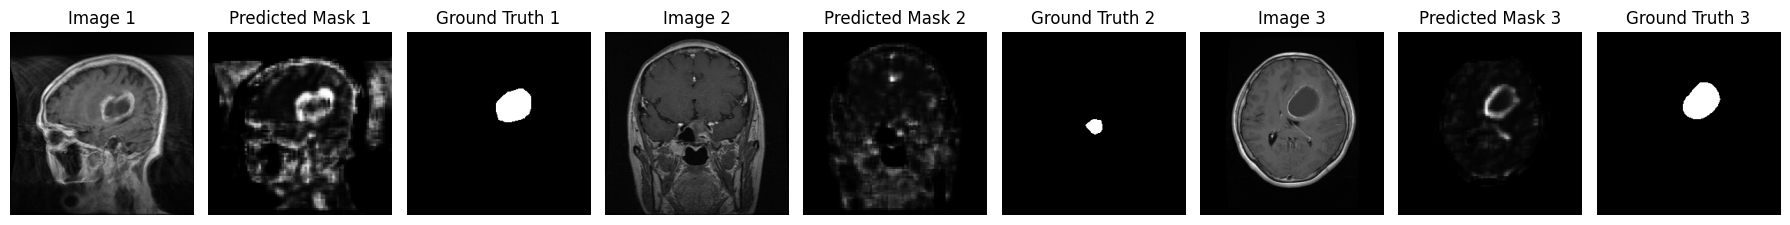

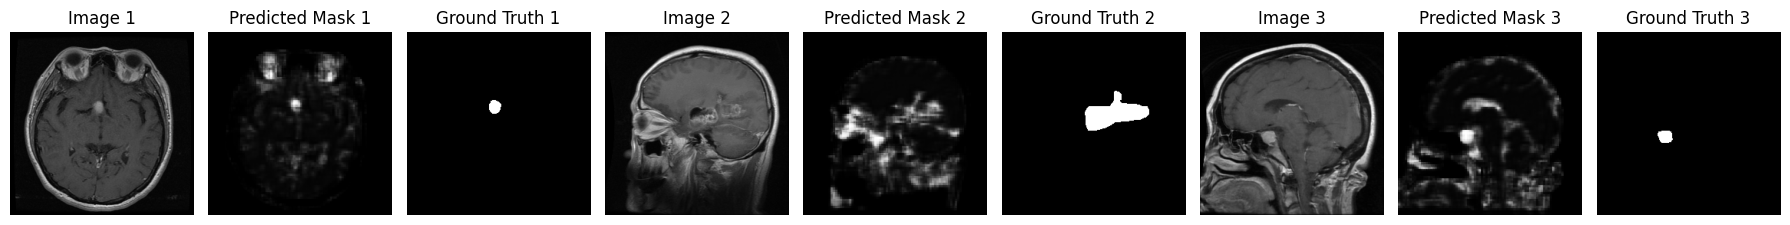

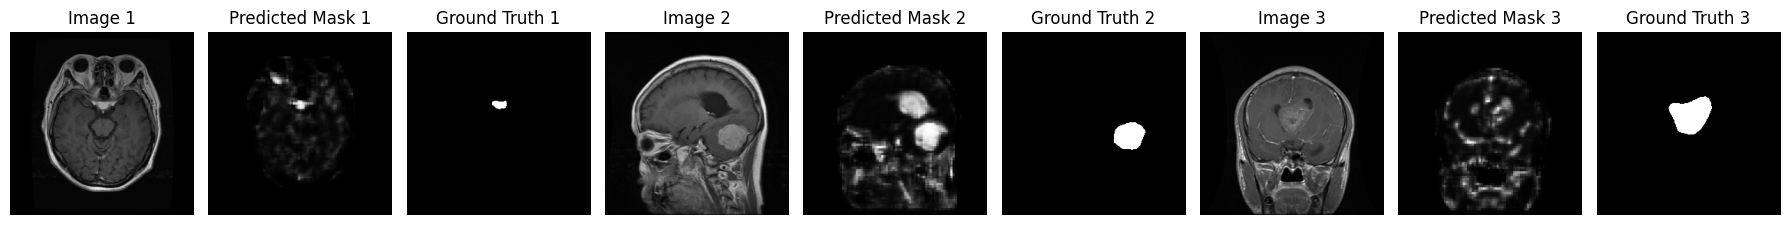

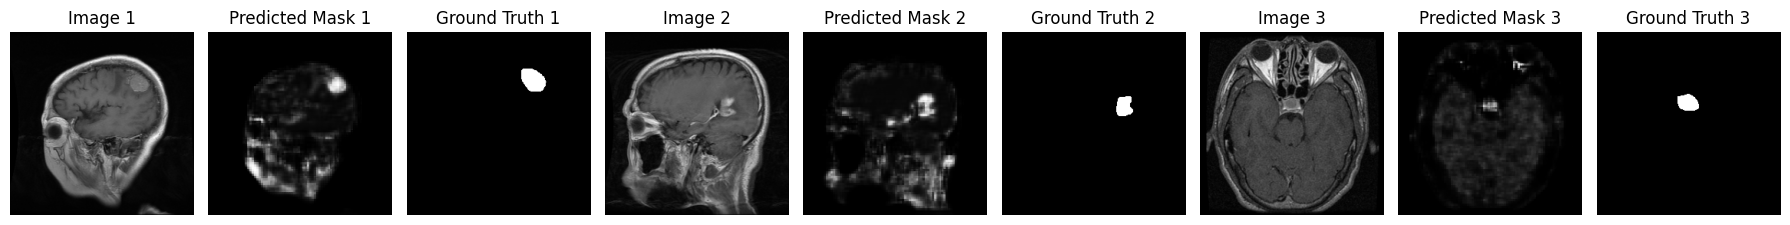

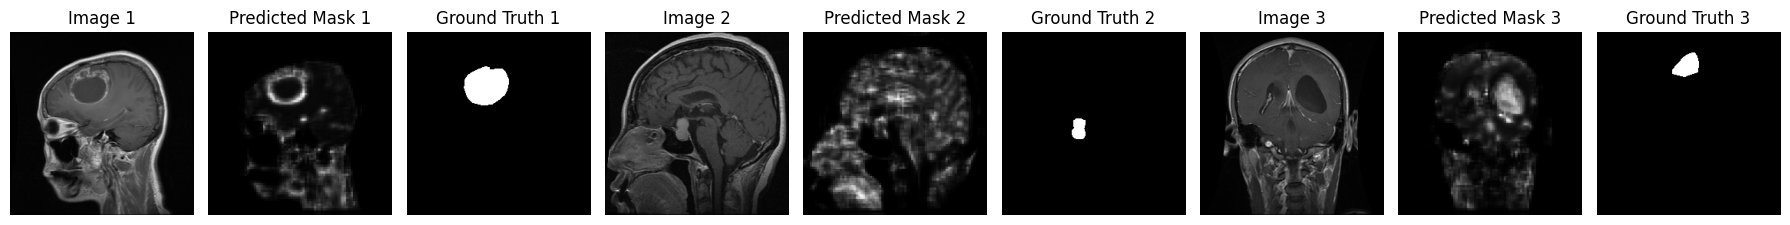

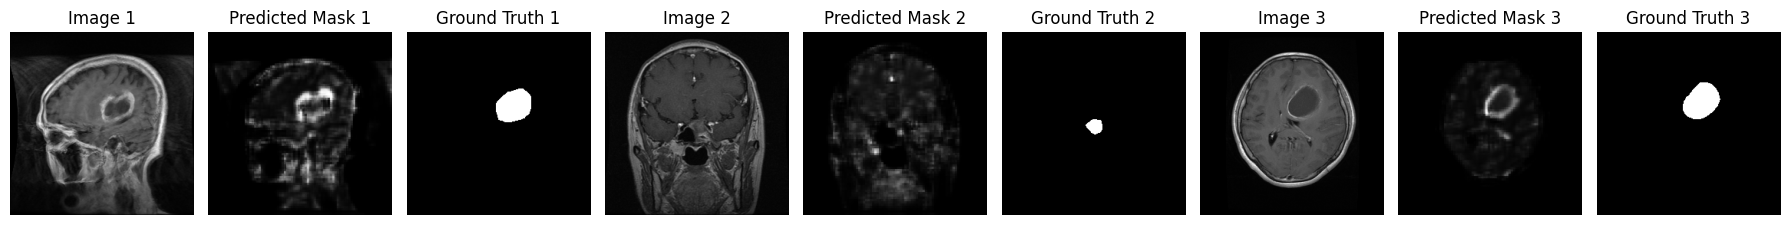

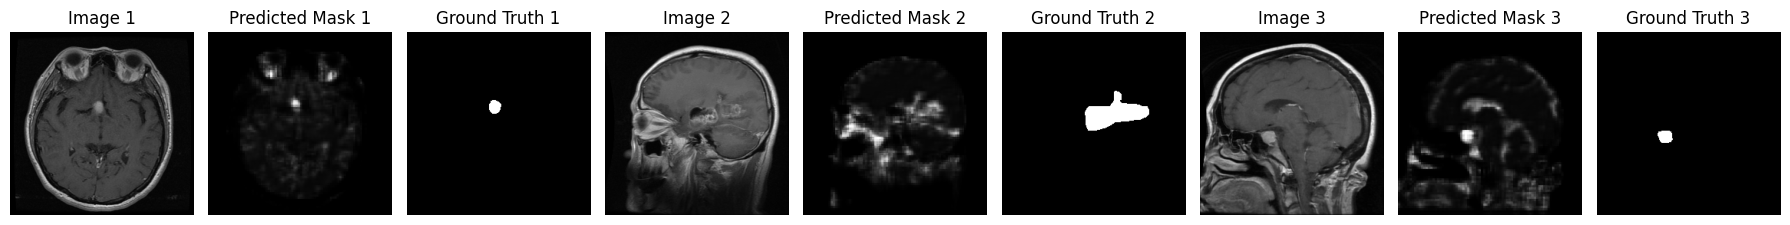

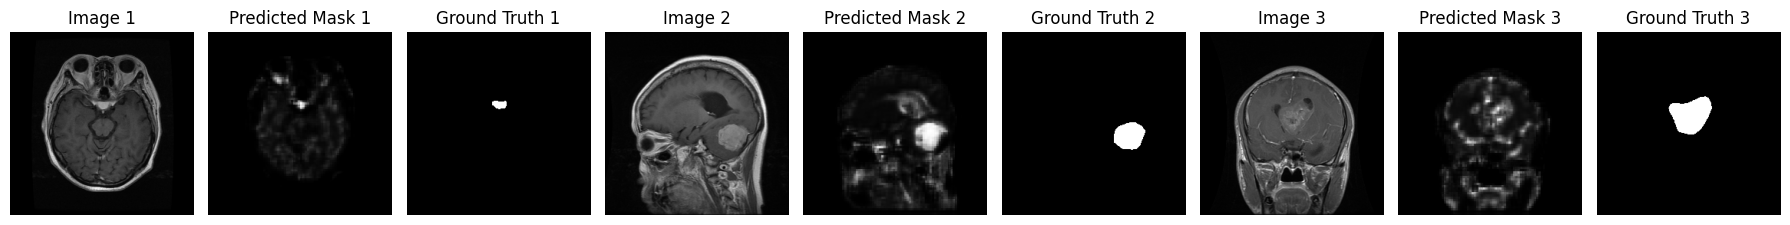

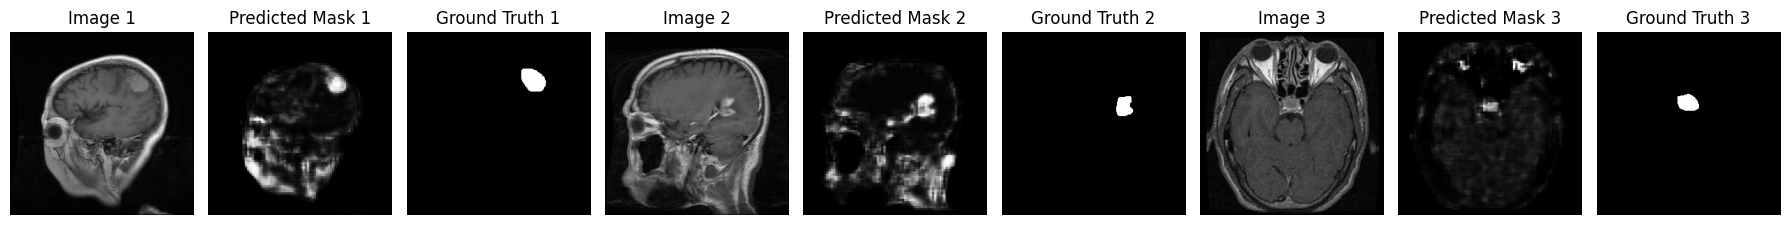

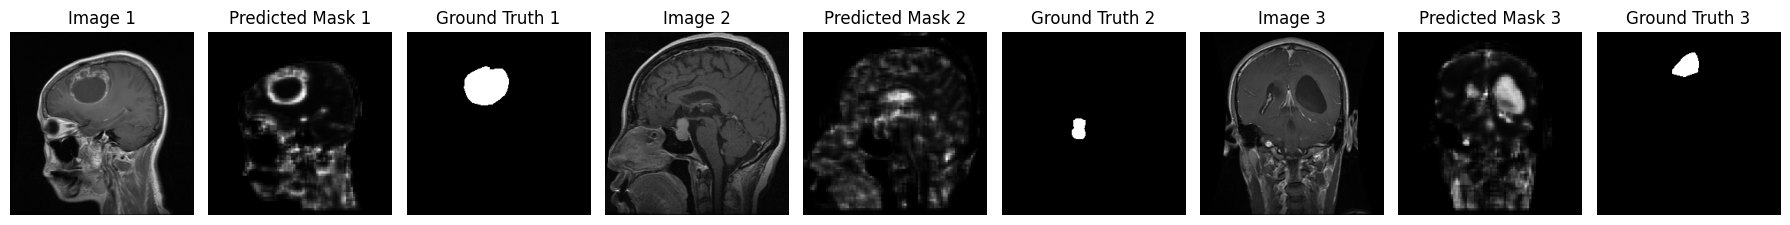

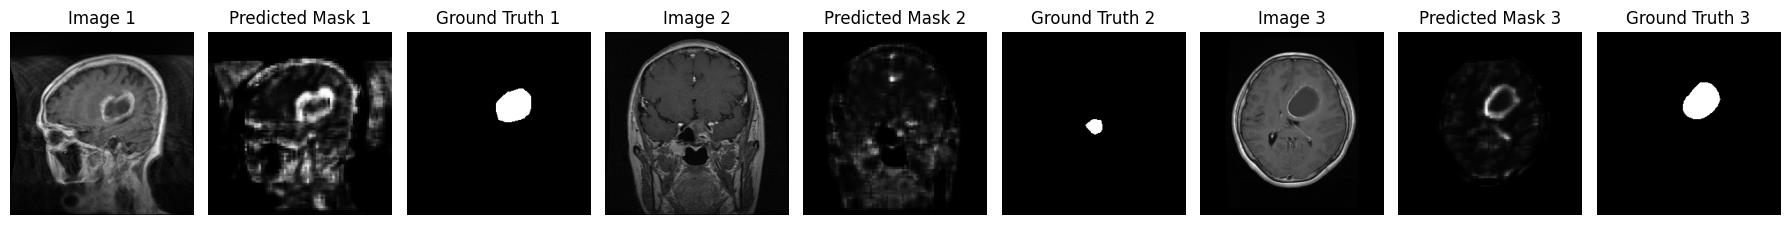

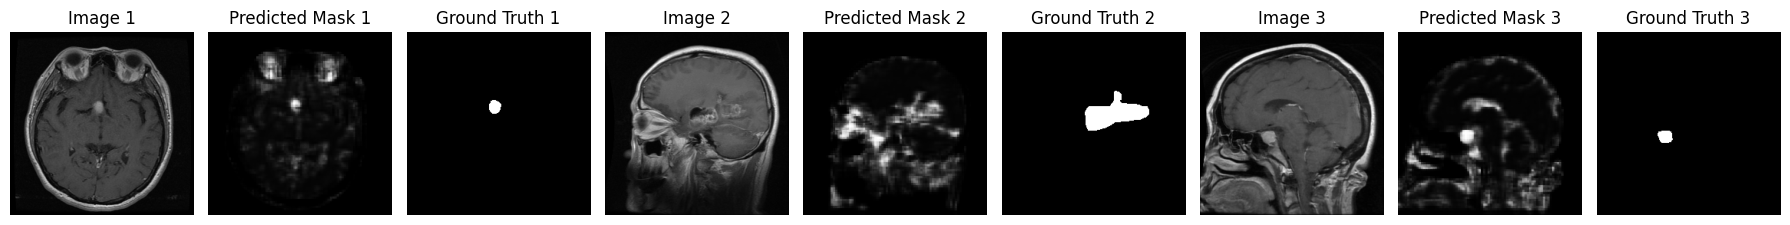

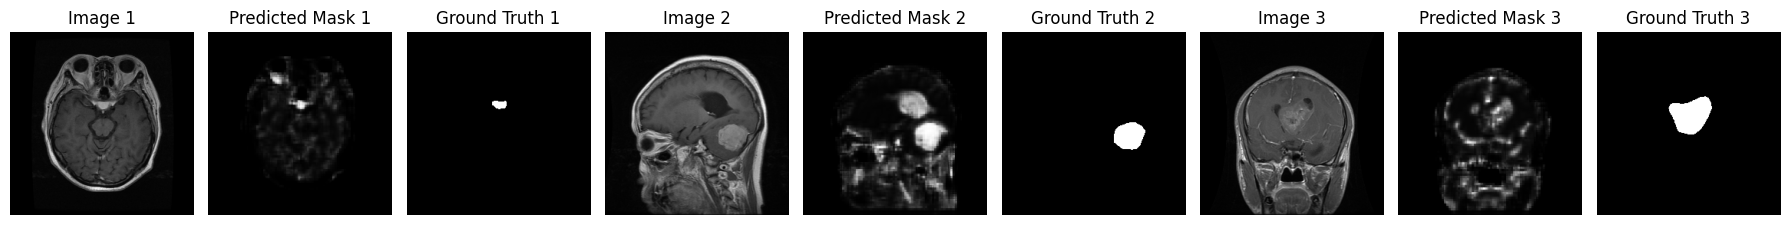

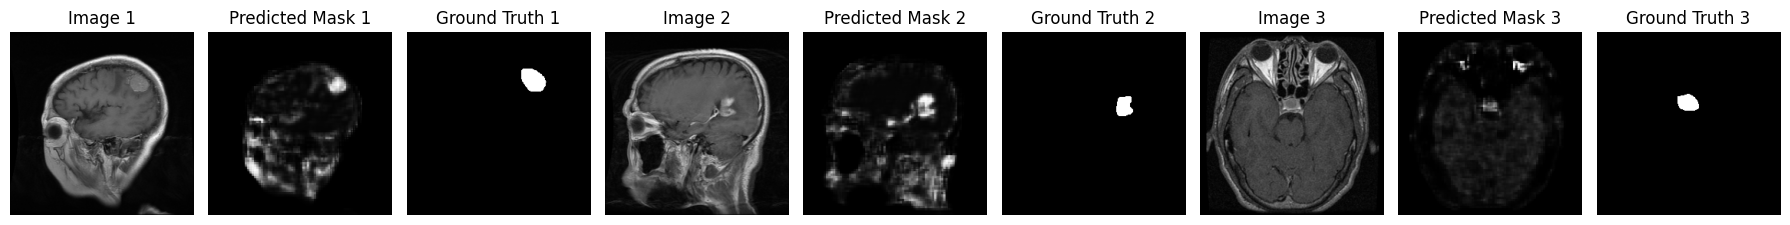

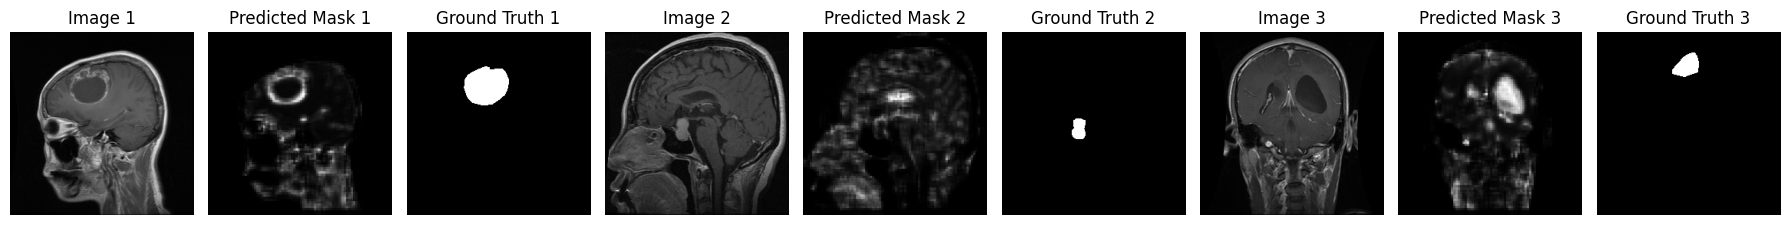

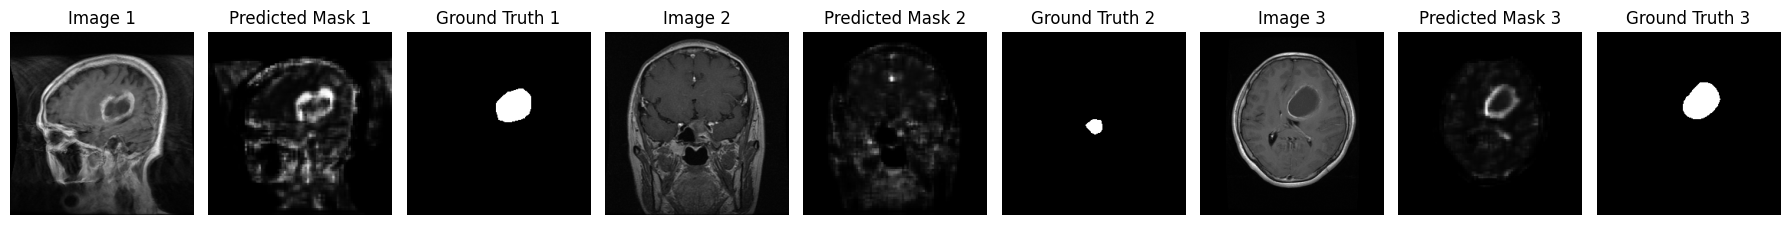

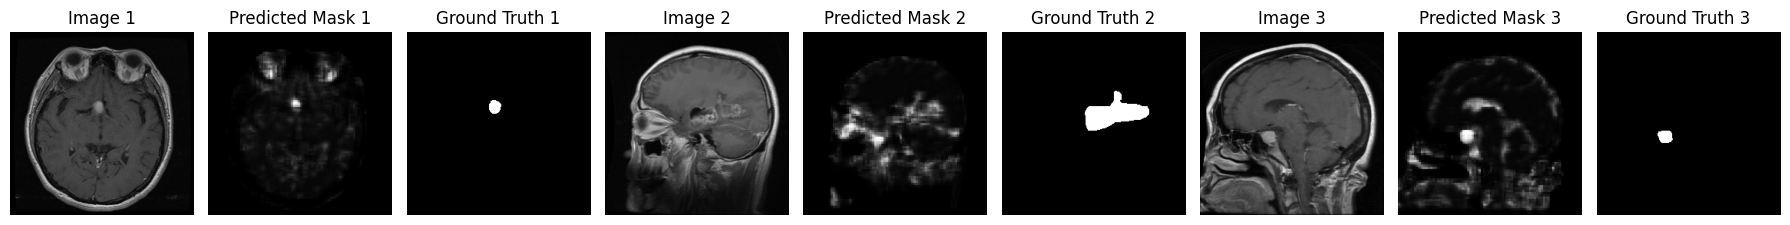

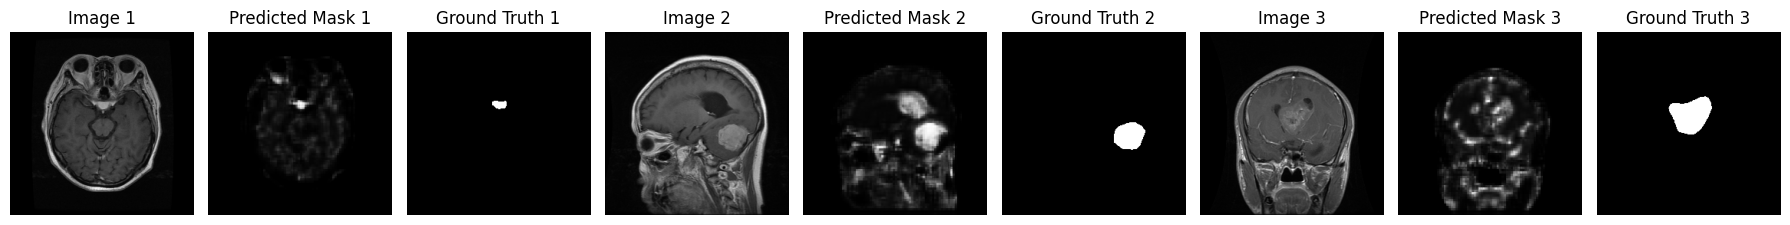

In [90]:
visualize_sample_outputs(sample_outputs)

### Iou Score Calculation and Dice Coefficient

In [91]:
def dice_coef(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 3) #round up to 3 decimal places

def iou(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = np.mean(intersect/union)
    return round(iou, 3)

In [92]:
true = []
pred = []
for imgs, mask in test_loader:
    true.extend([m.cpu().numpy().reshape(1, 240, 240) for m in mask])
    with torch.no_grad():
        imgs = imgs.reshape(-1, 1, 240, 240).cuda()
        outputs = model(imgs).detach().cpu().numpy()
    pred.extend([m for m in outputs])

true = np.array(true)
pred = np.array(pred)

In [93]:
print("Dice coefficient is:",dice_coef(true,pred))
print("IoU:", iou(true,pred))

Dice coefficient is: 0.182
IoU: 0.1
